# WES/OncoPanel overlap

Taking OncoPanel variants as a "ground truth," we want here to assess the degree of agreement between OncoPanel and WES in patients with both data types, considering sequence variants and CNAs separately.

This notebook generates the plots in Extended Data Fig. 1b,d.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [3]:
### Setup
vaf_threshold = 0.1

In [4]:
oncopanel_variants_path = "../data/oncopanel_mutations.csv" #'gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d96824cea2/merrell/oncopanel/data/AWG_GENOMIC_MUTATION_RESULTS.csv'
oncopanel_clinical_path = "../data/oncopanel_clinical.xlsx" #'gs://fc-secure-3f0f305e-f110-432b-bc9a-c8d96824cea2/merrell/oncopanel/data/AWG_CLINICAL_GBM_ICB_NGS_2-11-24.xlsx'
sample_sheet_path = '../data/sample_cohort_sheet.tsv'
wes_maf_path = '../data/icb_wes_mut_ccfs_maf.pickle'
# wes_pre_preprocessed_path = os.path.join(results_dir_local, '2023-12-15_pathway-mut-prep/muts_cnas_combined.pkl')

oncopanel_variants = pd.read_csv(oncopanel_variants_path, sep = '\t')
oncopanel_clinical = pd.read_excel(oncopanel_clinical_path)
sample_sheet = pd.read_csv(sample_sheet_path, sep = '\t')
wes_variants = pd.read_pickle(wes_maf_path)

# We'll eventually want to make these replacements further upstream, in the code that generates these files
wes_variants['Sample_ID'] = wes_variants['Sample_ID'].apply(lambda x: x.split('_pair')[0] if '_pair' in x else x)
wes_variants.replace({'GBM.ICB-3-14.637.Post.FFbank': 'GBM.ICB-3-14.233.Pre'}, inplace = True)

oncopanel_variants = oncopanel_variants.merge(oncopanel_clinical[['id_uniquesample', 'id_broad_sample']],
                                              how = 'left',
                                              on = 'id_uniquesample')
oncopanel_variants['Sample_ID'] = np.where(oncopanel_variants['id_broad_sample'].notnull(),
                                           oncopanel_variants['id_broad_sample'],
                                           oncopanel_variants['id_uniquesample']).astype(str)
oncopanel_variants.replace({'GBM.ICB-3-14.637.Post.FFbank': 'GBM.ICB-3-14.233.Pre'}, inplace = True)

Filter to patients with both OncoPanel and WES

In [5]:
sample_intersect = sample_sheet.loc[sample_sheet['usable_oncopanel'] & sample_sheet['usable_wes'], 'sample_id_legacy']
len(sample_intersect)

34

In [6]:
oncopanel_intersect = oncopanel_variants[oncopanel_variants['Sample_ID'].isin(sample_intersect)].reset_index(drop = True).copy()
wes_intersect = wes_variants[wes_variants['Sample_ID'].isin(sample_intersect)].reset_index(drop = True).copy()

In [7]:
print(oncopanel_intersect['Sample_ID'].nunique(), wes_intersect['Sample_ID'].nunique())

33 34


In [8]:
set(wes_intersect['Sample_ID']) - set(oncopanel_intersect['Sample_ID'])

{'GBM.ICB-36-16.111.B3.Pre'}

In [9]:
oncopanel_intersect.rename(columns = {'CHROMOSOME': 'Chr', 'POSITION': 'Pos', 'REF_ALLELE': 'Ref', 'ALT_ALLELE': 'Alt'}, inplace = True)
oncopanel_intersect['Pos'] = oncopanel_intersect['Pos'].astype(str)

wes_intersect['unique_mut_id_op_format'] = wes_intersect['unique_mut_id'].str.replace(':', '_').str.replace('>', '_').str.replace(r'(\d)([A-Za-z\-])', r'\1_\2', regex = True)
wes_intersect[['Chr', 'Pos', 'Ref', 'Alt']] = wes_intersect['unique_mut_id_op_format'].str.split('_', expand = True)

# deletion coords are off by 1
for i, row in wes_intersect.iterrows():
    if row['Alt'] == '-':
        wes_intersect.loc[i, 'Pos'] = str(int(row['Pos']) - 1)
    else:
        wes_intersect.loc[i, 'Pos'] = str(row['Pos'])
        
# make ref and alt coords in OncoPanel maf-like
for i, row in oncopanel_intersect.iterrows():
    if len(row['Alt']) > 1:
        oncopanel_intersect.loc[i, 'Alt'] = row['Alt'][1:]
        oncopanel_intersect.loc[i, 'Ref'] = '-'
    elif len(row['Ref']) > 1:
        oncopanel_intersect.loc[i, 'Ref'] = row['Ref'][1:]
        oncopanel_intersect.loc[i, 'Alt'] = '-'

In [10]:
comparison = oncopanel_intersect.merge(wes_intersect, how = 'left', left_on = ['Sample_ID', 'Chr', 'Pos', 'Ref', 'Alt'], right_on = ['Sample_ID', 'Chr', 'Pos', 'Ref', 'Alt'], indicator = 'in_wes')
comparison['in_wes'].value_counts()

left_only     86
both          73
right_only     0
Name: in_wes, dtype: int64

In [11]:
comparison["in_wes"].value_counts()

left_only     86
both          73
right_only     0
Name: in_wes, dtype: int64

73/159 OncoPanel mutations are also found in WES, and 86/159 are only found in OncoPanel.

In [12]:
comparison['Sample_ID'].nunique()

33

Questions to answer with plots:
- Is there a bias in VAF for mutations not called in WES?
- For mutations called in both OncoPanel and WES, do the allele frequencies agree?

In [13]:
comparison['in_wes_relabel'] = np.where(comparison['in_wes'] == 'left_only', 'OncoPanel only', 'OncoPanel + Exome')
comparison['in_wes_relabel'].value_counts()

OncoPanel only       86
OncoPanel + Exome    73
Name: in_wes_relabel, dtype: int64

Some variants don't have a gnomAD frequency provided.

In [14]:
comparison['MAX_GNOMAD_FREQUENCY_na0'] = comparison['MAX_GNOMAD_FREQUENCY'].fillna(0.0).astype(float)

In [15]:
overlap = comparison[comparison['in_wes_relabel'] == 'OncoPanel + Exome'].copy()\
    .rename(columns = {'ALLELE_FRACTION': 'OP_ALLELE_FRACTION'})
overlap['WES_ALLELE_FRACTION'] = 100 * (overlap['t_alt_count']) / (overlap['t_alt_count'] + overlap['t_ref_count'])
overlap.shape

(73, 172)

Some variants don't have an allele fraction reported by OncoPanel.

In [16]:
overlap[overlap['OP_ALLELE_FRACTION'].isnull()]

,id_drspatient,id_uniquesample,id_icb,id_mj,VARIANT_CALL_ID,CANONICAL_GENE,BEST_EFF_GENE,CANONICAL_VARIANT_CLASS,BEST_EFF_VARIANT_CLASS,HARMONIZED_HUGO_GENE_NAME,...,preDP_ccf_1.0,unique_mut_id,variant_type,clonal_status,postDP_ccf_mode,unique_mut_id_op_format,in_wes,in_wes_relabel,MAX_GNOMAD_FREQUENCY_na0,WES_ALLELE_FRACTION
138,1019543071,1019543903042,249.0,NaN,9951471,NaN,NaN,intergenic_variant,upstream_gene,TERT,...,0.101035,5:1295228G>A,non_coding,clonal,1.0,5_1295228_G_A,both,OncoPanel + Exome,0.0,45.345345


In [17]:
overlap = overlap[overlap['OP_ALLELE_FRACTION'].notnull()]

/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_31386/1138450189.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='in_wes_relabel', y='ALLELE_FRACTION', data=comparison, width=.6, palette='vlag', fliersize=0, ax = ax1)
/var/folders/37/f0kgv16d10q0_dy3d9lsxqbr0000gq/T/ipykernel_31386/1138450189.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='in_wes_relabel', y='MAX_GNOMAD_FREQUENCY_na0', data=comparison, width=.6, palette='vlag', fliersize=0, ax = ax2)


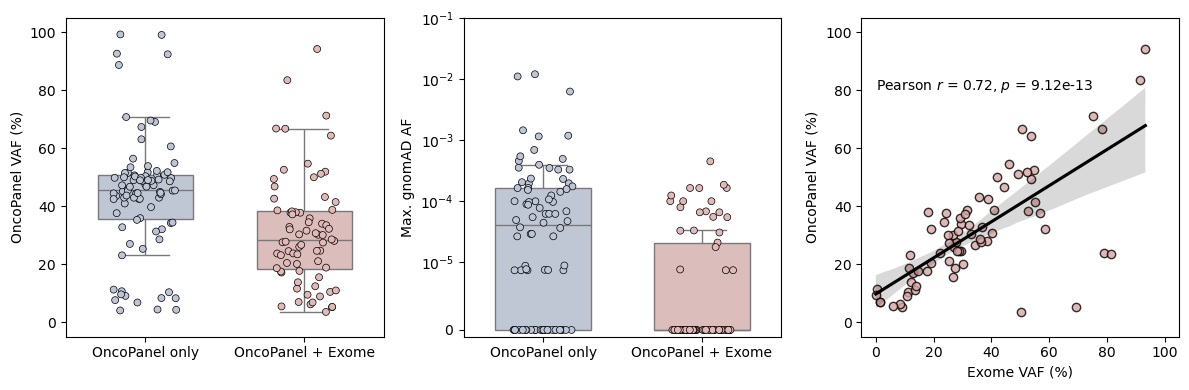

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout = 'tight', figsize = (12,4))

# A
sns.stripplot(x='in_wes_relabel', y='ALLELE_FRACTION', data=comparison, jitter=0.2, hue='in_wes_relabel', palette='vlag',
             edgecolor='k', linewidth=0.5, legend=False, ax = ax1)

sns.boxplot(x='in_wes_relabel', y='ALLELE_FRACTION', data=comparison, width=.6, palette='vlag', fliersize=0, ax = ax1)

ax1.set_ylim(-5,105)
ax1.set_ylabel('OncoPanel VAF (%)')
ax1.set_xlabel(None)

# B
sns.stripplot(x='in_wes_relabel', y='MAX_GNOMAD_FREQUENCY_na0', data=comparison, jitter=0.2, hue='in_wes_relabel', palette='vlag',
             edgecolor='k', linewidth=0.5, legend=False, ax = ax2)
sns.boxplot(x='in_wes_relabel', y='MAX_GNOMAD_FREQUENCY_na0', data=comparison, width=.6, palette='vlag', fliersize=0, ax = ax2)

ax2.set_yscale('symlog', linthresh = 1e-5)
ax2.set_ylim(-1e-6, 1e-1)
ax2.set_ylabel('Max. gnomAD AF')
ax2.set_xlabel(None)

# C
r, p = pearsonr(overlap['WES_ALLELE_FRACTION'], overlap['OP_ALLELE_FRACTION'])
ax3.text(0, 80, 'Pearson $r$ = {:.2f}, $p$ = {:.2e}'.format(r, p))

sns.regplot(x='WES_ALLELE_FRACTION', y='OP_ALLELE_FRACTION', data=overlap,
            line_kws={'color': 'k'},
            scatter_kws={'color': sns.color_palette('vlag')[-2], 'edgecolor': 'k'})
ax3.set_xlim(-5,105)
ax3.set_ylim(-5,105)
ax3.set_xlabel('Exome VAF (%)')
ax3.set_ylabel('OncoPanel VAF (%)')

plt.show()

Conclusion: most variants that are exclusive to OncoPanel are either germline (thus filtered out in tumor-normal processing) or very low VAF (thus not called because of lower coverage in WES).

For both of these possibilities, I spot-checked a few mutations in IGV in either the normal (for likely germline) or the tumor (for low-VAF variants).